In [1]:
######### Package Imports #########################################################################
import os, warnings, copy, torch, ax
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from botorch.acquisition.logei import qLogNoisyExpectedImprovement
from ax.modelbridge.transforms.standardize_y import StandardizeY
from ax.modelbridge.transforms.unit_x import UnitX
from ax.modelbridge.transforms.remove_fixed import RemoveFixed
from ax.modelbridge.transforms.log import Log
from ax.core.base_trial import TrialStatus as T
from ax.utils.notebook.plotting import init_notebook_plotting, render
from ax.plot.slice import plot_slice

from optimpv import *
from optimpv.axBOtorch.axBOtorchOptimizer import axBOtorchOptimizer
from optimpv.RateEqfits.RateEqAgent import RateEqAgent
from optimpv.RateEqfits.RateEqModel import *
from optimpv.RateEqfits.Pumps import *

init_notebook_plotting()
warnings.filterwarnings('ignore') 
##############################################################################################
# Define the parameters to be fitted
params = []

k_direct = FitParam(name = 'k_direct', value = 1e-16, bounds = [1e-18,1e-15], log_scale = True, rescale = True, value_type = 'float', type='range', display_name=r'$k_{\text{direct}}$', unit='m$^{3}$ s$^{-1}$', axis_type = 'log')
params.append(k_direct)

k_trap = FitParam(name = 'k_trap', value = 2e6, bounds = [1e5,1e7], log_scale = True, rescale = True, value_type = 'float', type='range', display_name=r'$k_{\text{trap}}$', unit='s$^{-1}$', axis_type = 'log')
params.append(k_trap)

# I_factor = FitParam(name = 'I_factor_PL', value = 1e-27, bounds = [1e-28,1e-26], log_scale = True, rescale = True, value_type = 'float', type='range', display_name=r'$I_{\text{PL}}$', unit='-', axis_type = 'log')
# params.append(I_factor)

I_factor = FitParam(name = 'I_factor_MC', value = 1e-27, bounds = [1e-28,1e-26], log_scale = True, rescale = True, value_type = 'float', type='range', display_name=r'$I_{\text{PL}}$', unit='-', axis_type = 'log')
params.append(I_factor)

ratio_mu = FitParam(name = 'ratio_mu', value = 3, bounds = [1,100], log_scale = True, rescale = True, value_type = 'float', type='range', display_name=r'$\mu_{\text{ratio}}$', unit='-', axis_type = 'linear')
params.append(ratio_mu)

# original values
params_orig = copy.deepcopy(params)
dum_dic = {}
for i in range(len(params)):
    dum_dic[params[i].name] = params[i].value/params[i].fscale # we need this just to run the model to generate some fake data

[INFO 12-10 11:36:30] ax.utils.notebook.plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.
[INFO 12-10 11:36:30] ax.utils.notebook.plotting: Please see
    (https://ax.dev/tutorials/visualizations.html#Fix-for-plots-that-are-not-rendering)
    if visualizations are not rendering.


# test trMC

In [2]:
t = np.geomspace(1e-9, 1e-3, 1000)
# add 0 to the time array
t = np.insert(t, 0, 0)
# remove the last values
t = t[:-500]

Gfracs = [0.1,0.5,1]
# concatenate the time and Gfracs
X = None
for Gfrac in Gfracs:
    if X is None:
        X = np.array([t,Gfrac*np.ones(len(t))]).T
    else:
        X = np.concatenate((X,np.array([t,Gfrac*np.ones(len(t))]).T),axis=0) 

y_ = X # dummy data

# Define the agents
metric = 'mse'
loss = 'soft_l1'
threshold = 10
exp_format = 'trMC'
pump_args = {'N0': 1e24, 'fpu': 1e3 , 'background' : 0, }

RateEq_fake = RateEqAgent(params, [X], [y_], model = BT_model, pump_model = initial_carrier_density, pump_args = pump_args, fixed_model_args = {}, metric = metric, loss = loss, threshold=threshold,minimize=True,exp_format=exp_format,compare_logs=True)

(1503,)


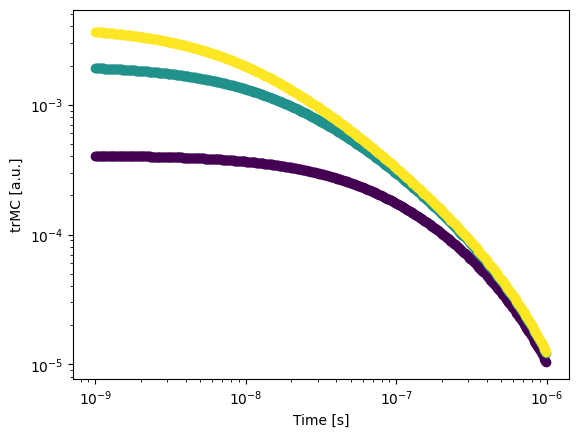

In [3]:
y = RateEq_fake.run(dum_dic,exp_format=exp_format)
print(y.shape)
plt.figure()
viridis = plt.cm.get_cmap('viridis', len(Gfracs))
for idx, Gfrac in enumerate(Gfracs):
    plt.plot(X[X[:,1]==Gfrac,0], y[X[:,1]==Gfrac],'o',label=str(Gfrac), color=viridis(idx))
    # plt.plot(t, y_[X[:,1]==Gfrac],label=str(Gfrac)+'_', color=viridis(Gfrac), linestyle='--')
# plt.plot(X[:,0], y,'o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time [s]')
plt.ylabel(exp_format + ' [a.u.]')
plt.show()


In [4]:
RateEq = RateEqAgent(params, [X], [y], model = BT_model, pump_model = initial_carrier_density, pump_args = pump_args, fixed_model_args = {}, metric = metric, loss = loss, threshold=threshold,minimize=True,exp_format=exp_format,compare_logs=True)

In [5]:
# Define the model kwargs
model_kwargs_list = [{},{'torch_device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),'torch_dtype': torch.double,'botorch_acqf_class':qLogNoisyExpectedImprovement,'transforms':[RemoveFixed, Log,UnitX, StandardizeY]}]

# Define the optimizer
optimizer = axBOtorchOptimizer(params = params, agents = RateEq, models = ['SOBOL','BOTORCH_MODULAR'],n_batches = [1,40], batch_size = [10,2], ax_client = None,  max_parallelism = -1, model_kwargs_list = model_kwargs_list, model_gen_kwargs_list = None, name = 'ax_opti')

In [6]:
optimizer.optimize()

[INFO 12-10 11:36:30] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 12-10 11:36:30] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='k_direct', parameter_type=FLOAT, range=[0.01, 10.000000000000002], log_scale=True), RangeParameter(name='k_trap', parameter_type=FLOAT, range=[0.1, 10.0], log_scale=True), RangeParameter(name='I_factor_MC', parameter_type=FLOAT, range=[0.09999999999999999, 10.0], log_scale=True), RangeParameter(name='ratio_mu', parameter_type=FLOAT, range=[1.0, 100.0], log_scale=True)], parameter_constraints=[]).
[INFO 12-10 11:36:30] ax.service.ax_client: Generated new trial 0 with parameters {'k_direct': 0.108229, 'k_trap': 0.138674, 'I_factor_MC': 0.226323, 'ratio_mu': 48.920382} using model Sobol.
[INFO 12-10 11:36:30] ax.service.ax_client: Generated new trial 

In [7]:
ax_client = optimizer.ax_client
best_parameters = ax_client.get_best_parameters()[0]
print(best_parameters)
RateEq.params_w(best_parameters,RateEq.params)


{'k_direct': 1.196989983095743, 'k_trap': 1.0599701194429483, 'I_factor_MC': 1.991438193919321, 'ratio_mu': 1.0}


[{'name': 'k_direct', 'type': 'range', 'value_type': 'float', 'value': np.float64(1.1969899830957428e-16), 'bounds': [1e-18, 1e-15], 'values': None, 'start_value': 1e-16, 'log_scale': True, 'fscale': np.float64(1e-16), 'stepsize': None, 'rescale': True, 'display_name': '$k_{\\text{direct}}$', 'unit': 'm$^{3}$ s$^{-1}$', 'full_name': '$k_{\\text{direct}}$ [m$^{3}$ s$^{-1}$]', 'axis_type': 'log', 'std': None, 'encoding': None, 'force_log': False},
 {'name': 'k_trap', 'type': 'range', 'value_type': 'float', 'value': np.float64(1059970.1194429484), 'bounds': [100000.0, 10000000.0], 'values': None, 'start_value': 2000000.0, 'log_scale': True, 'fscale': np.float64(1000000.0), 'stepsize': None, 'rescale': True, 'display_name': '$k_{\\text{trap}}$', 'unit': 's$^{-1}$', 'full_name': '$k_{\\text{trap}}$ [s$^{-1}$]', 'axis_type': 'log', 'std': None, 'encoding': None, 'force_log': False},
 {'name': 'I_factor_MC', 'type': 'range', 'value_type': 'float', 'value': np.float64(1.9914381939193213e-27), 

In [8]:
# plot the evolution of the optimization
render(ax_client.get_contour_plot(param_x="k_direct", param_y="k_trap", metric_name=optimizer.all_metrics[0]))

model = ax_client.generation_strategy.model

render(plot_slice(model=model, param_name="k_direct", metric_name=optimizer.all_metrics[0]))


[INFO 12-10 11:39:54] ax.service.ax_client: Retrieving contour plot with parameter 'k_direct' on X-axis and 'k_trap' on Y-axis, for metric 'RateEq_trMC_mse'. Remaining parameters are affixed to the middle of their range.


Text(0, 0.5, 'log of RateEq_trMC_mse')

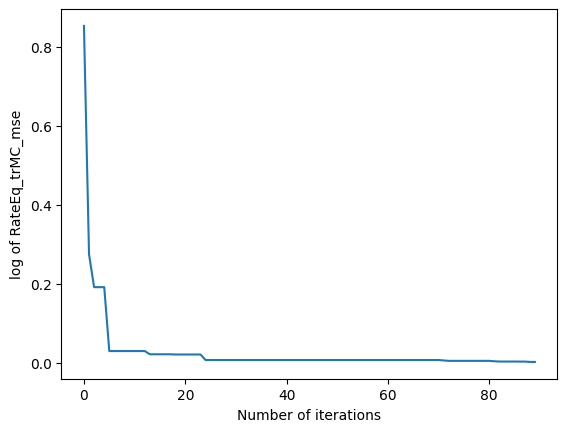

In [9]:
data = ax_client.experiment.fetch_data()

plt.plot(np.minimum.accumulate(data.df["mean"]), label="Best value seen so far")

plt.xlabel("Number of iterations")
plt.ylabel('log of ' + optimizer.all_metrics[0])


In [10]:
# create dic with keys same as ax_client.experiment.trials[0].arm.parameters
dumdic = {}
for key in ax_client.experiment.trials[0].arm.parameters.keys():
    dumdic[key] = []

# fill the dic with the values of the parameters
for i in range(len(ax_client.experiment.trials)):
    if ax_client.experiment.trials[i].status == T.COMPLETED:
        for key in ax_client.experiment.trials[i].arm.parameters.keys():
            dumdic[key].append(ax_client.experiment.trials[i].arm.parameters[key])

data = ax_client.experiment.fetch_data().df

dumdic[optimizer.all_metrics[0]] = data['mean']

df = pd.DataFrame(dumdic)

for par in params:
    if par.name in df.columns:
        if par.rescale:
            df[par.name] = df[par.name] * par.fscale


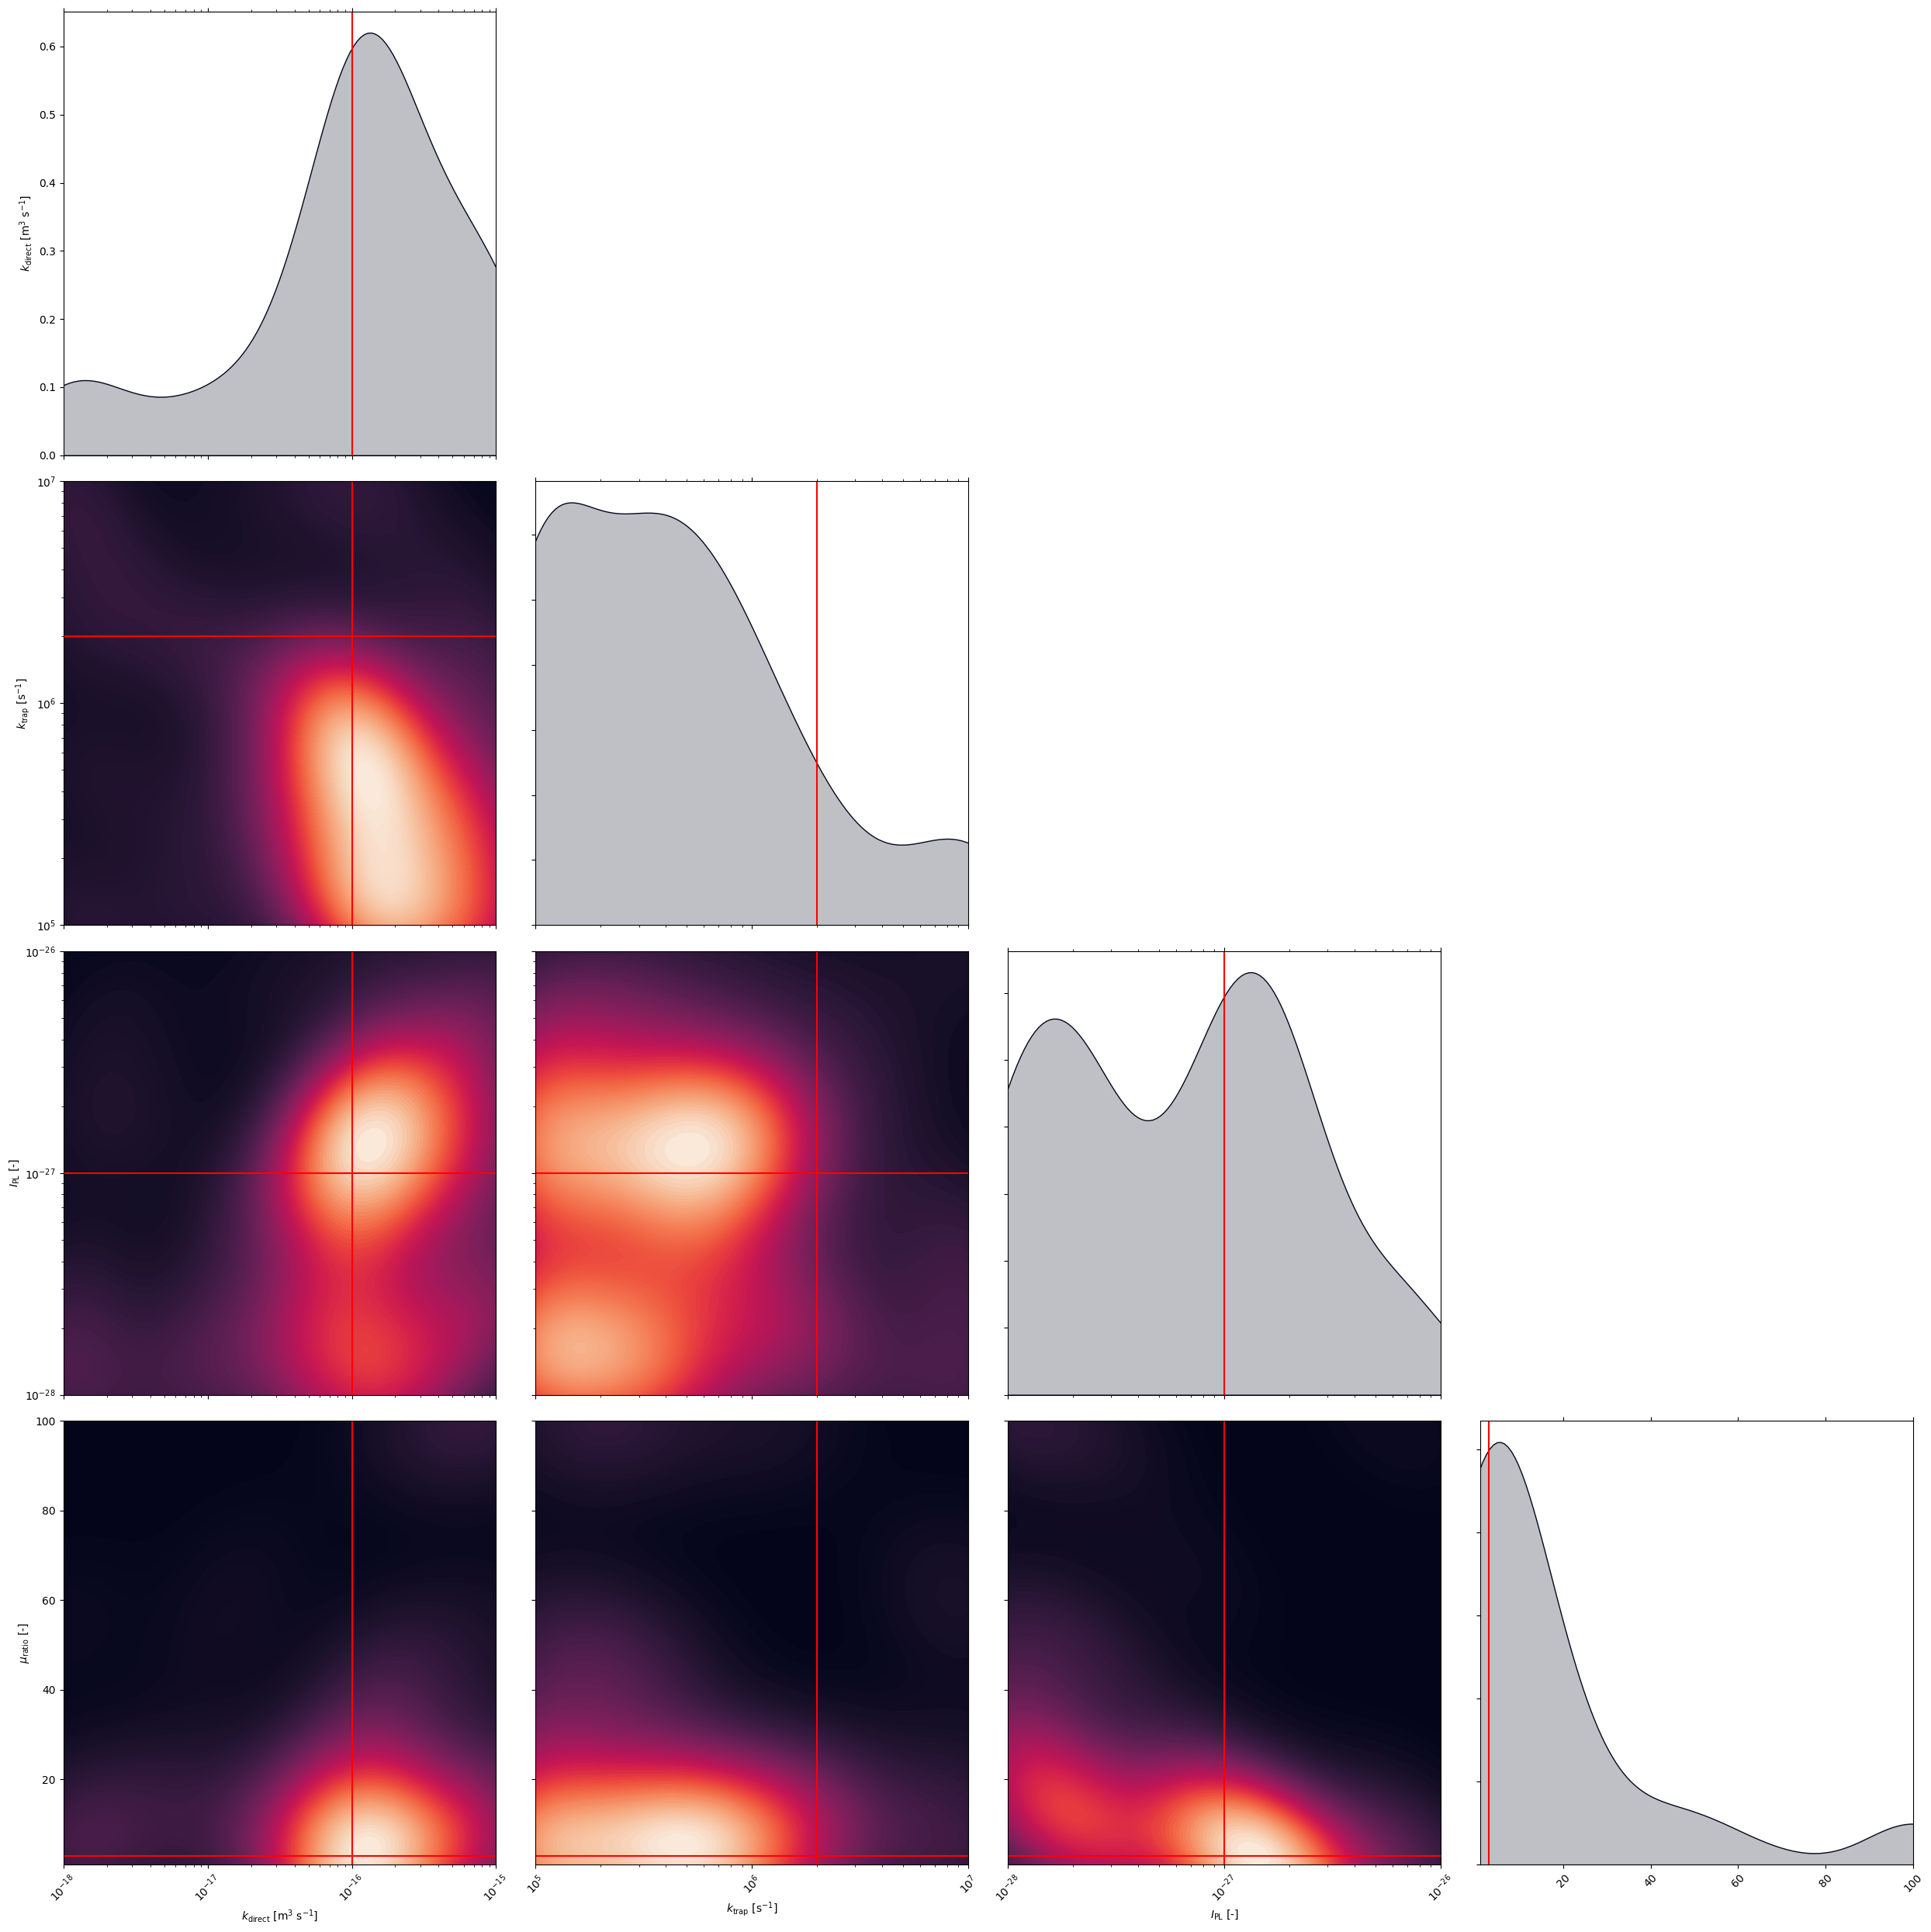

In [11]:
# get name of all parameters that are not 'fixed'
names = []
display_names = []
log_scale = []
axis_limits = []
for p in params:
    if p.type != 'fixed':
        names.append(p.name)
        display_names.append(p.display_name + ' [' + p.unit + ']')
        log_scale.append(p.axis_type == 'log')
        axis_limits.append(p.bounds)

# Get all combinations of names
comb = list(combinations(names, 2))

# Determine the grid size
n = len(names) 

fig, axes = plt.subplots(n, n, figsize=(25, 25))

# Plot each combination in the grid
for i, xx in enumerate(names):
    for j, yy in enumerate(names):
        xval = np.nan
        yval = np.nan

        for p in params_orig:
            if p.name == xx:
                xval = p.value
            if p.name == yy:
                yval = p.value

        ax = axes[i, j]
        
        if i == j:
            # kde plot on the diagonal
            sns.kdeplot(x=yy, data=df, ax=ax, fill=True, thresh=0, levels=100, cmap="rocket", color="#03051A", log_scale=log_scale[names.index(xx)])

            ax.axvline(x=yval, color='r', linestyle='-')
            # put point at the best value top of the axis
           

            if log_scale[names.index(yy)]:
                ax.set_xscale('log')
                ax.set_xlim(axis_limits[names.index(yy)])
            else:
                ax.set_xlim(axis_limits[names.index(yy)])
            
            # put x label on the top
            # except for the last one
            if i < n - 1:
                ax.xaxis.set_label_position('top')
                ax.xaxis.tick_top()

        elif i > j:
            kind = 'kde'
            if kind == 'scatter':
                sns.scatterplot(x=yy, y=xx, data=df, ax=ax, color="#03051A")
                ax.set_xscale('log')
                ax.set_yscale('log')
            else:
                sns.kdeplot(x=yy, y=xx, data=df, ax=ax, fill=True, thresh=0, levels=100, cmap="rocket", color="#03051A", log_scale=(log_scale[names.index(yy)], log_scale[names.index(xx)]))

            xval = np.nan
            yval = np.nan
            for p in params_orig:
                if p.name == xx:
                    xval = p.value
                elif p.name == yy:
                    yval = p.value

            # Plot as line over the full axis
            ax.axhline(y=xval, color='r', linestyle='-')
            ax.axvline(x=yval, color='r', linestyle='-')
            ax.scatter(best_parameters[yy], best_parameters[xx], c='y', marker='*', s=200, zorder=10)
            
            ax.set_xlim(axis_limits[names.index(yy)])
            ax.set_ylim(axis_limits[names.index(xx)])
        else:
            ax.set_visible(False)


        if j == 0:
            ax.set_ylabel(display_names[i])
        else:
            ax.tick_params(axis='y', which='both', left=True, labelleft=False)
            ax.set_ylabel('')

        if i == n - 1:
            ax.set_xlabel(display_names[j])
            # rotate x labels
            ax.tick_params(axis='x', rotation=45, which='both')
        else:
            ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False)
            ax.set_xlabel('')

        # if i==0 and j==0:
        #     ax.tick_params(axis='y', which='both', left=True, labelleft=False)
        #     ax.set_ylabel('')

        if i == j:
            # xlabel at the top
            ax.tick_params(axis='x', which='both', top=True, labeltop=False)
            # ax.xaxis.set_label_position('top')
            # ax.set_xlabel(display_names[j])
            ax.set_xlabel('')


        # Optionally, set labels for the last row and first column
        # else:
        #     if i == 0:
        #         ax.set_xlabel(yy)
        #     if j == 0:
        #         ax.set_ylabel(xx)
        
plt.tight_layout()
plt.show()

(1503,)


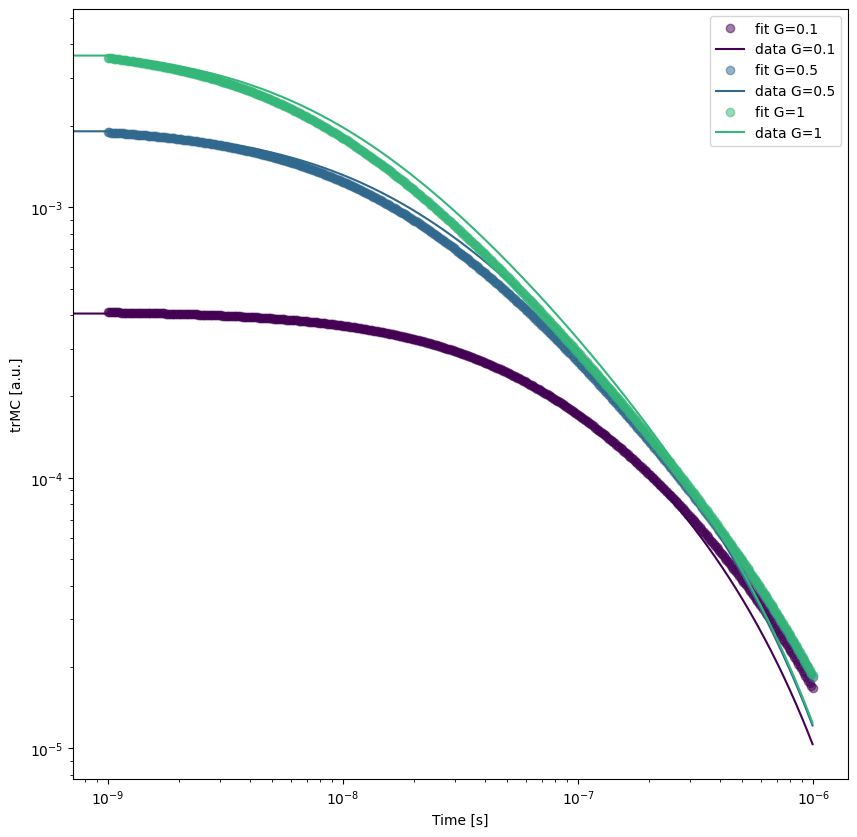

In [12]:
# rerun the simulation with the best parameters
yfit = RateEq.run(parameters=ax_client.get_best_parameters()[0],exp_format=exp_format)
print(yfit.shape)
plt.figure(figsize=(10,10))

viridis = plt.cm.get_cmap('viridis', 4)
for idx, Gfrac in enumerate(Gfracs):
    plt.plot(X[X[:,1]==Gfrac,0], yfit[X[:,1]==Gfrac],'o',label='fit G='+str(Gfrac),alpha=0.5,color=viridis(idx))
    plt.plot(X[X[:,1]==Gfrac,0], y[X[:,1]==Gfrac],'-',label='data G='+str(Gfrac),color=viridis(idx))
    
# plt.plot(X[:,0],y,'o',label='data')
# plt.plot(X[:,0],yfit,'o',label='fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time [s]')
plt.ylabel(exp_format + ' [a.u.]')
plt.legend()
plt.show()